<a href="https://colab.research.google.com/github/wgova/time_series_trade/blob/master/notebooks/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [4]:
!pip install -q oec
import oec
import pandas as pd
import numpy as np
import json
from random import sample
import random
import itertools

import os, os.path, csv, requests, pathlib
from datetime import datetime
import math
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## OEC data API functions

In [0]:
# Functions adapted from https://github.com/yahiaali/oec for OEC API calls
def build_call(*args):
    call_url = 'http://atlas.media.mit.edu/'
    for val in args:
        call_url += str(val) + '/'
    return call_url


def request_data(call_url):
    r = requests.get(call_url)
    response_dict = r.json()
    json_list = response_dict['data']  # list of dicts containing data
    return json_list


def get_countries(filename=None):
    call = build_call('attr', 'country')
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def get_products(classification, filename=None):
    call = build_call('attr', classification)
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def get_trade(classification, trade_flow, year, origin, destination,product, filename=None):
    call = build_call(classification, trade_flow, year, origin, destination,
                      product)
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def trade_params(classification, trade_flow, year, origin, destination,product):
    parameters = {'classification': classification,
                  'trade_flow': trade_flow,
                  'year': year,
                  'origin': origin,
                  'destination': destination,
                  'product': product}
    return parameters


def get_header(json_list):
    header = set()
    for dict in json_list:
        header.update(dict.keys())
    header = list(header)
    header.sort()
    return header


def create_csv(json_list, filename):
    with open(filename, 'w') as csvfile:
        header = get_header(json_list)
        cw = csv.writer(csvfile)
        cw.writerow(header)
        for dict in json_list:
            row = dict_to_list(dict, header)
            cw.writerow(row)


def dict_to_list(dict, header):
    row = []
    for field in header:
        if field in dict:
            row.append(str(dict[field]))
        else:
            row.append(None)
    return row


### Custom functions
def get_countries_and_products():
  countries = get_countries()
  products = get_products(trade_classification)
  create_csv(countries,f'{PATH}/list_countries.csv')
  create_csv(products,f'{PATH}/list_products.csv')

def download_data(list_of_codes):
  for i in trade_codes:
    csv_name = f"{trade_classification}-{i}"
    # Set parameters to extract top exporters from the API documentation
    params = {'classification': trade_classification,
          'trade_flow': 'export',
          'year': 'all',
          'origin': 'show', #Set origin to all for comparison
          'destination': 'all',
          'product': i} #Set code for product of interest
    print(f'Processing data for {i}.....')
    oec_data = get_trade(**params)
    # Save the results in CSV file
    if path.exists(PATH):
      create_csv(oec_data,f'{csv_name}.csv')
    else:
      print('Choose destination directory')

def create_df(path:str):
  trade_data = [i for i in os.listdir(path) if i.startswith('sitc') and '.csv' in i]
  print(f'List of csv files contentated into one dataframe \n: {tuple(trade_data)} \n \n')
  trade_history = []
  for file in trade_data:
    file_df = pd.read_csv(
        os.path.join(path,file),
        parse_dates=['year'])
    trade_history.append(file_df)
  products_dataframe = pd.concat(trade_history)
  return products_dataframe

def underscore_header_names(df):
  '''
  Renaming product names after aggregation with pivot tables
  '''
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
  return df.columns

def remove_null_values(df,threshold:int=0.8):
  pct_null = df.isnull().sum() / len(df)
  missing_features = pct_null[pct_null > threshold].index
  df.drop(missing_features, axis=1, inplace=True)
  df.fillna(0,inplace=True)

## Generate dataset
- OEC API endpoint down as at 16 June 2020

- This data has been downloaded and saved in the folder indicated
No need to run this if there no new data needed



In [0]:
# Generate lists for countries and products
PATH = '/content/drive/My Drive/Stellenbosch/Webster'
trade_classification = 'sitc'
# get_countries_and_products()
trade_codes = ['6519','6531','8471','6571','7849','7810','7842','7764',
               '7723','7522','2924','5419','5417','7763','7711','7188']
# download_data(trade_codes)

In [7]:
# Load trade data
include_list = ['year','origin_id','sitc_id','export_val','export_rca']
trade_data = create_df(PATH)
trade_df = trade_data[include_list]

# Load country names
country_list = pd.read_csv(f'{PATH}/list_countries.csv',usecols=['id','name'],
                        na_values='',na_filter=True)
country_list.rename(columns=lambda x: x.replace('name','country'), inplace=True)
country_list.rename(columns=lambda x: x.replace('id','origin_id'), inplace=True)

# Update country names
trade_dframe = trade_df.merge(country_list, on=['origin_id'],how='inner')
trade_dframe['sitc_id'].astype('category')
trade_dframe.fillna(0,inplace=True)

# Load product list
products = pd.read_csv(f'{PATH}/list_products.csv',usecols=['id','name','display_id'])
products.rename(columns={'id':'sitc_id'},inplace=True)
products = products[products['display_id'].isin(trade_codes)]
products['name'] = products.name.astype('category')

# Update product names in dataframe
products['sitc_id'] = products.sitc_id.astype(int)
trade_dframe['product_name'] = trade_dframe.sitc_id.map(products\
                                                        .set_index('sitc_id')['name']\
                                                        .to_dict())

# Rename long product names
dict_of_name_options = {'Yarn of Textile Fibers':'yarn_fiber',
             'Synthetic Woven Fabrics':'synthetic_fiber',
             'Textile Fabrics Clothing Accessories':'accessory_fabrics',
             'Vehicles Parts and Accessories':'vehicle_parts',
             'Personal Computers':'computers',
             'Pharmaceutical Flora':'pharma_flora',
             'Non-Medicinal Pharmaceutical Products':'non_medicinals',
             'Diodes, Transistors and Photocells':'diodes_transistors_photocells',
             'Miscellaneous Engines':'engines_misc'
             }
trade_dframe['product_name']= trade_dframe['product_name'].map(
    dict_of_name_options)\
    .fillna(trade_dframe['product_name'])

# Remove unspecified country names included in the list  
unknown_origin_list = {'Areas',
                       'United States Unspecified',
                       'Northern Africa',
                       'Other Africa Not Elsewhere Specified',
                       'Europe Other Not Elsewhere Specified',
                       'European Union Not Elsewhere Specified',
                       'Neutral Zone'}
trade_dframe = trade_dframe[~trade_dframe['country'].isin(unknown_origin_list)]

# Checking for countries with 'x' in origin_id
s = trade_dframe['origin_id'].astype(str)
x_country = list(s[s.str.contains('x')].unique())
unspecified = trade_dframe[trade_dframe['origin_id'].isin(x_country)]
print(f'\n Checking if countries to exclude is successful : \n {unspecified["country"].unique()}')

List of csv files contentated into one dataframe 
: ('sitc-6519.csv', 'sitc-6531.csv', 'sitc-7842.csv', 'sitc-8471.csv', 'sitc-7764.csv', 'sitc-6571.csv', 'sitc-7723.csv', 'sitc-7522.csv', 'sitc-7849.csv', 'sitc-5417.csv', 'sitc-7810.csv', 'sitc-2924.csv', 'sitc-7763.csv', 'sitc-7711.csv', 'sitc-5419.csv', 'sitc-7188.csv') 
 


 Checking if countries to exclude is successful : 
 ['Mexico' 'Areas' 'Other Asia' 'Saint Kitts, Nevis and Anguilla'
 'Christmas Island' 'China Free Trade Zone (FTZ)' 'Belgium-Luxembourg'
 'United States Unspecified' 'Luxembourg' 'Northern Africa'
 'Other Africa Not Elsewhere Specified' 'Oceania'
 'Europe Other Not Elsewhere Specified'
 'European Union Not Elsewhere Specified' 'Neutral Zone'
 'British Antarctic Territory']


## Plots from pivot table aggregates
* South africa
* Country trade basket
* Export comparison for countries (random country examples)

In [1]:
random.seed(20)
random_country = sample(list(agg_country.columns), 5)
agg_south_africa = pd.pivot_table(trade_dframe[trade_dframe.country==random_country], index='year', columns='product_name', values='export_val', aggfunc=np.mean)
agg_south_africa.fillna(0,inplace=True)
underscore_header_names(agg_south_africa)
agg_south_africa.plot(subplots=True,figsize=(10, 12),title="Exports for South Africa in trade basket",sharey=False)
plt.show()

NameError: ignored

In [0]:
# https://pbpython.com/pandas-pivot-table-explained.html
agg_product = pd.pivot_table(trade_dframe, index='year', columns='product_name', values='export_val', aggfunc=np.mean)
remove_null_values(agg_product)
underscore_header_names(agg_product)

agg_country = pd.pivot_table(trade_dframe, index='year', columns='country', values='export_val', aggfunc=np.mean)
remove_null_values(agg_country)

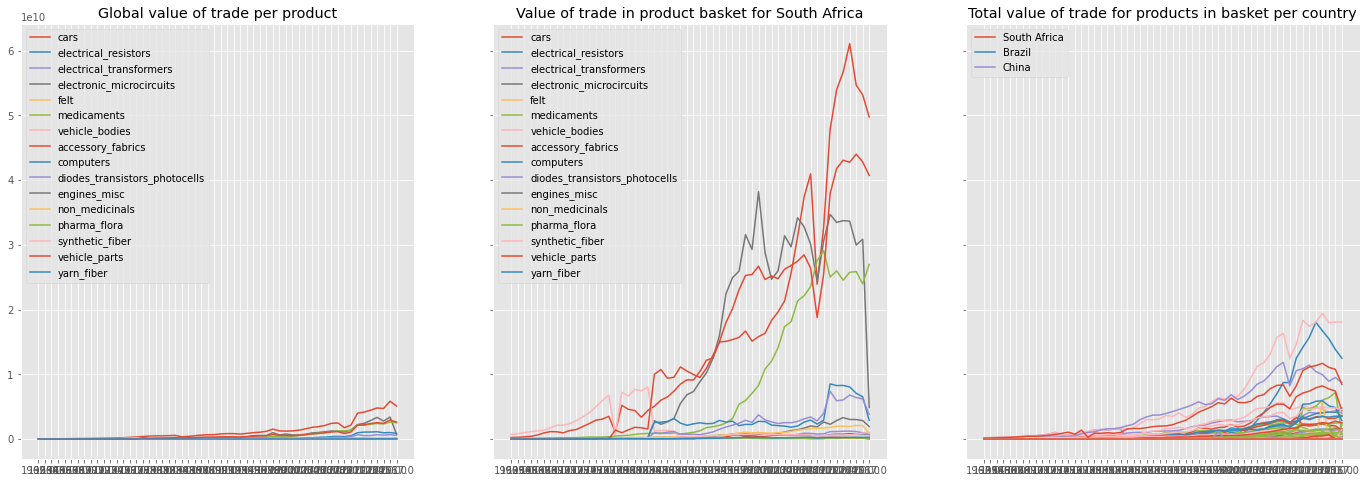

In [11]:
fig, ((ax1, ax2,ax3)) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True,figsize=(24, 8))
ax1.plot(agg_product)
ax1.title.set_text("Global value of trade per product")
ax1.legend(agg_product.columns,loc="upper left")

ax2.plot(agg_south_africa)
ax2.title.set_text("Value of trade in product basket for South Africa")
ax2.legend(agg_south_africa.columns,loc="upper left")

ax3.plot(agg_country)
ax3.title.set_text("Total value of trade for products in basket per country")
ax3.legend(['South Africa','Brazil','China'],loc="upper left")
# plt.plot(agg_south_africa,'--')
plt.show()

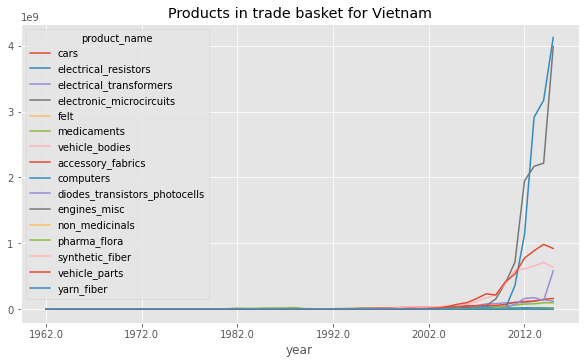

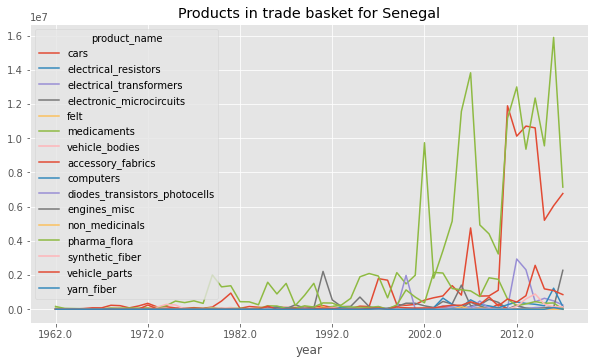

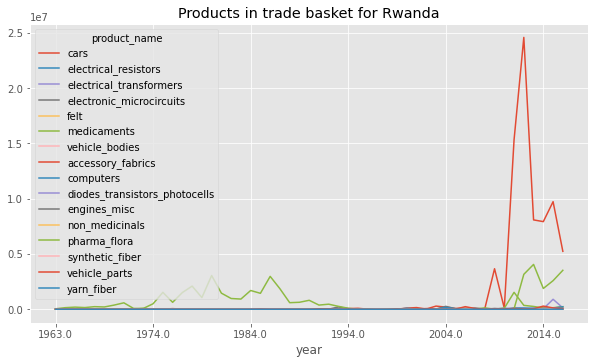

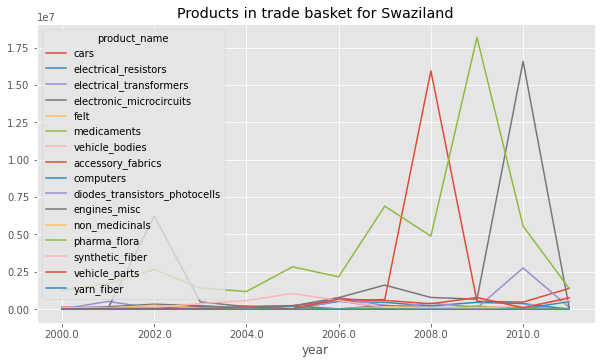

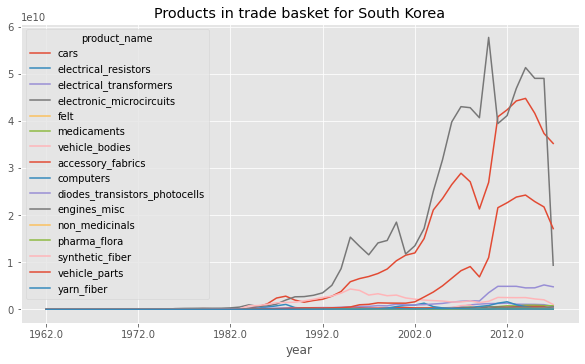

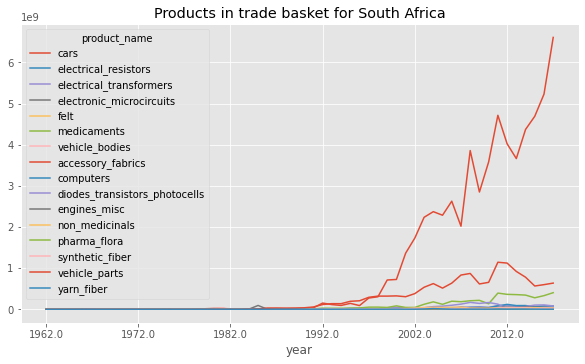

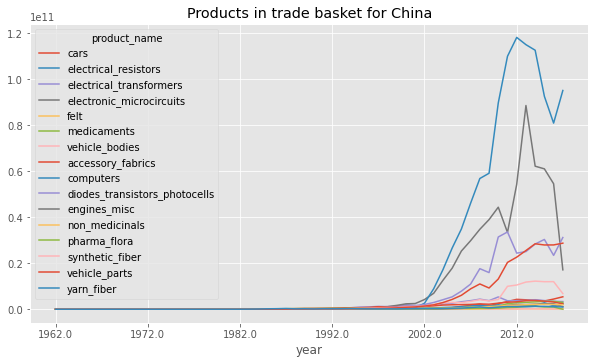

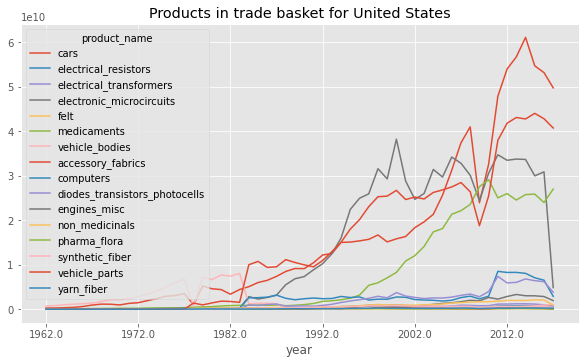

In [12]:
random.seed(20)
random_countries = sample(list(agg_country.columns), 5)
random_countries.extend(['South Africa','China','United States'])
for c in random_countries:
  agg_random_countries = pd.pivot_table(trade_dframe[trade_dframe.country==c], 
                                        index='year', columns='product_name', 
                                        values='export_val',
                                        aggfunc=np.mean)
  agg_random_countries.fillna(0,inplace=True)
  underscore_header_names(agg_random_countries)
  agg_random_countries.plot(subplots=False,figsize=(10,5.5),title=f"Products in trade basket for {c}",sharey=True)

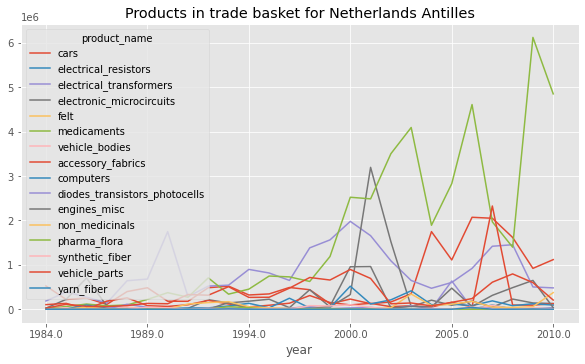

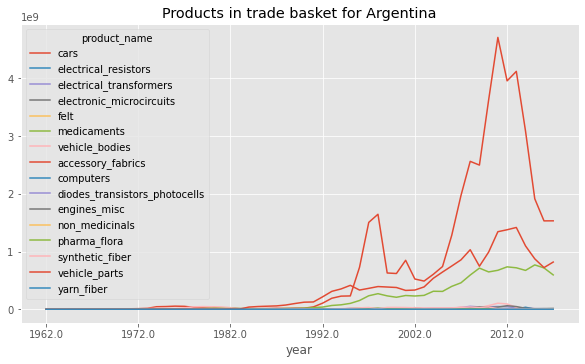

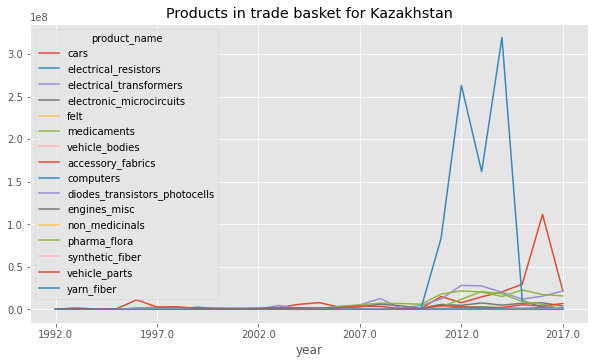

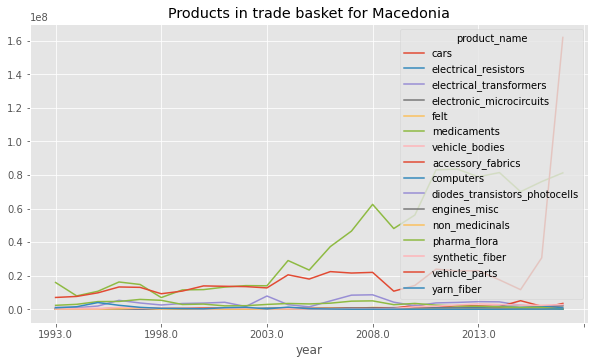

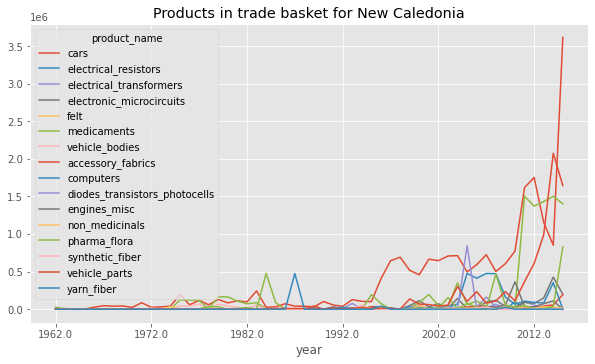

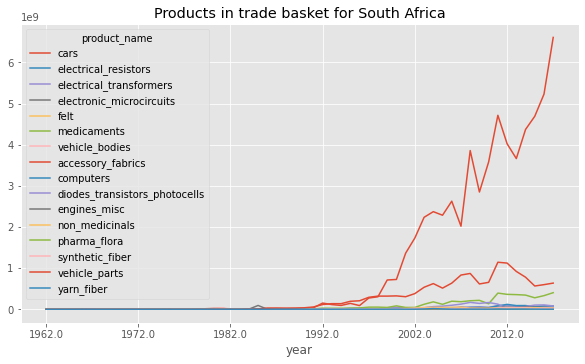

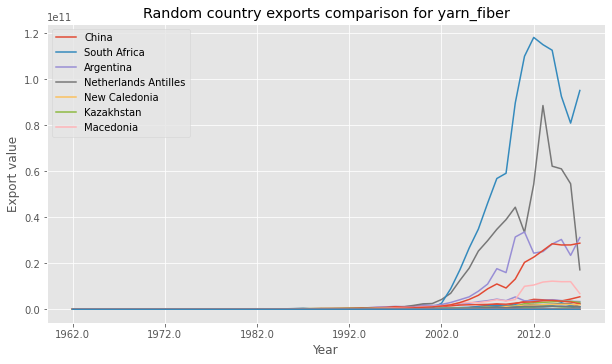

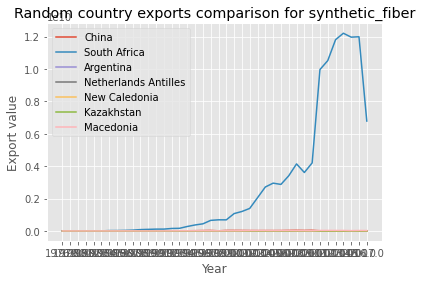

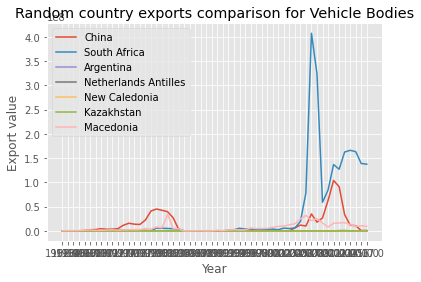

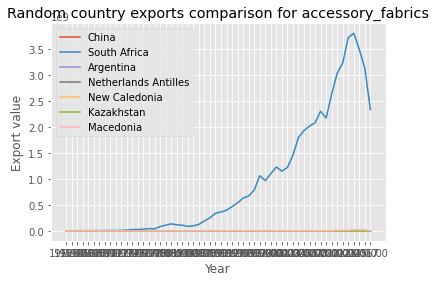

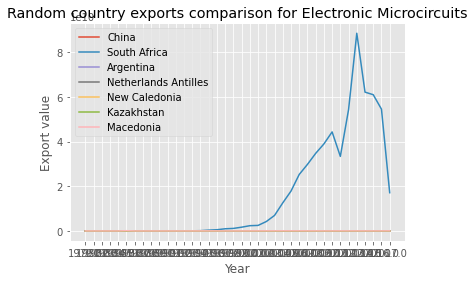

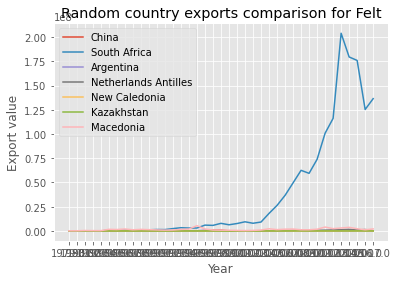

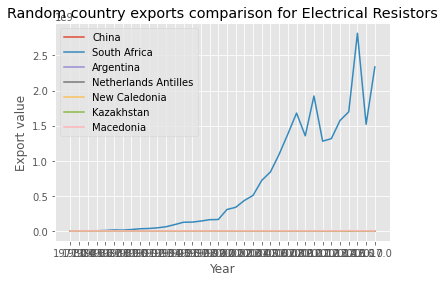

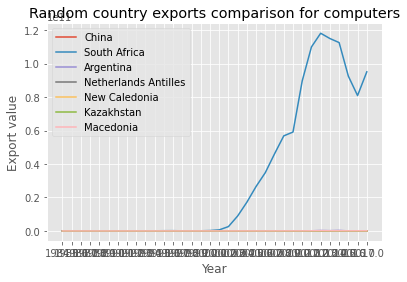

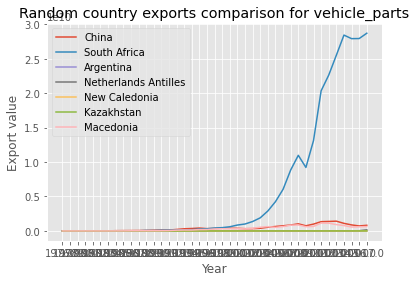

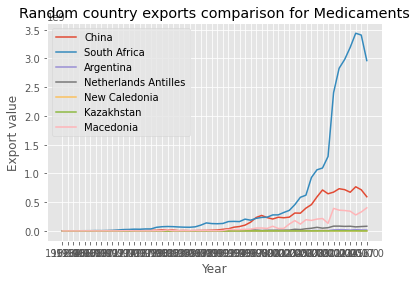

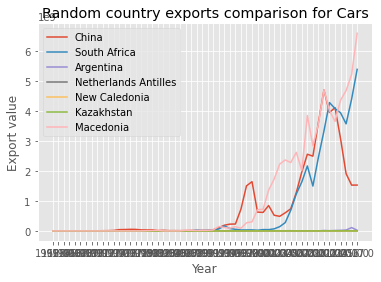

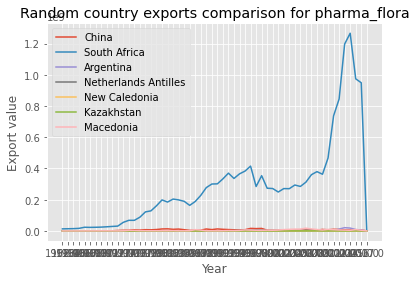

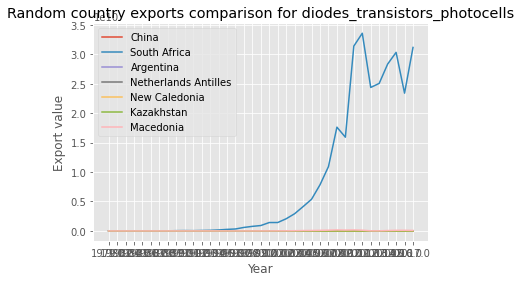

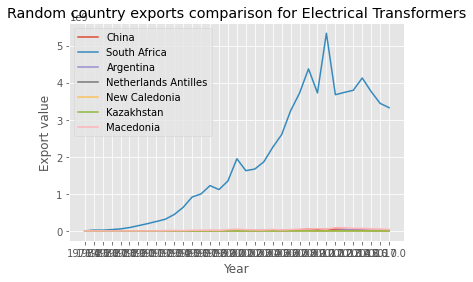

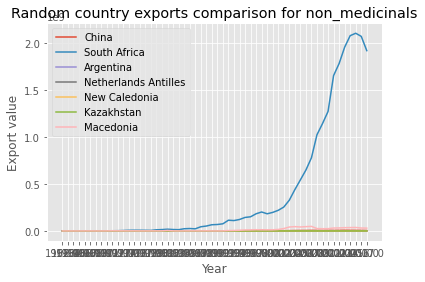

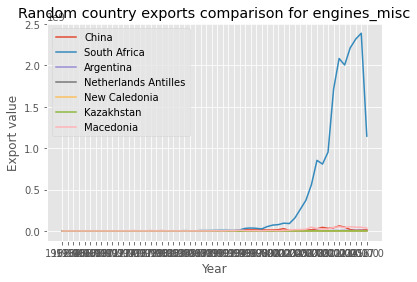

In [13]:
random.seed(10)
random_countries = sample(list(agg_country.columns), 5)
random_countries.extend(['South Africa','China'])
countries = trade_dframe[trade_dframe['country'].isin(random_countries)]
for c in random_countries:
  agg_random_countries = pd.pivot_table(trade_dframe[trade_dframe.country==c], 
                                        index='year', columns='product_name', 
                                        values='export_val',
                                        aggfunc=np.mean)
  agg_random_countries.fillna(0,inplace=True)
  underscore_header_names(agg_random_countries)
  agg_random_countries.plot(subplots=False,figsize=(10,5.5),title=f"Products in trade basket for {c}",sharey=True)

# Plots for country comparison per product 
for id in trade_dframe.product_name.unique():
  product = pd.pivot_table(trade_dframe[trade_dframe.product_name==id], 
                           index='year', 
                           columns='country', 
                           values='export_val', 
                           aggfunc=np.mean)
  product.fillna(0,inplace=True)
  product.to_csv(f'{PATH}/products_per_country/{id}_sitc.csv')
  product_by_countries = pd.pivot_table(countries[countries.product_name==id], index='year', 
                           columns='country', 
                           values='export_val', 
                           aggfunc=np.mean)
  product_by_countries.fillna(0,inplace=True)
  plt.plot(product_by_countries)
  plt.title(f"Random country exports comparison for {id}")
  plt.xlabel("Year")
  plt.ylabel("Export value")
  plt.legend(countries['country'].unique())
  plt.show()

## Rescale time series to the global mean for the product

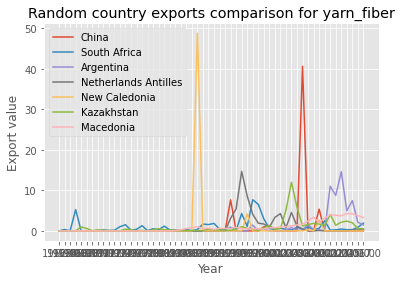

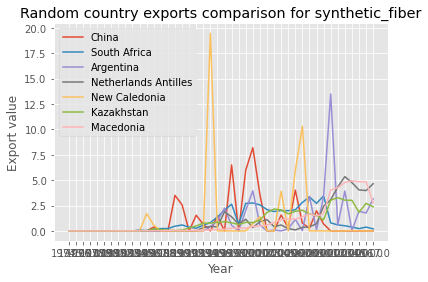

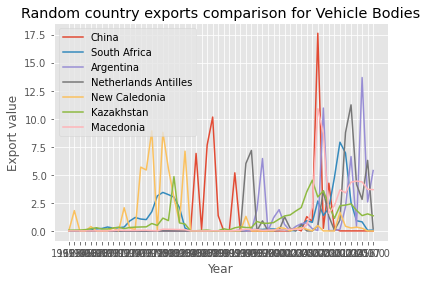

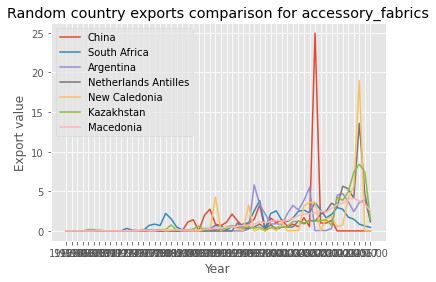

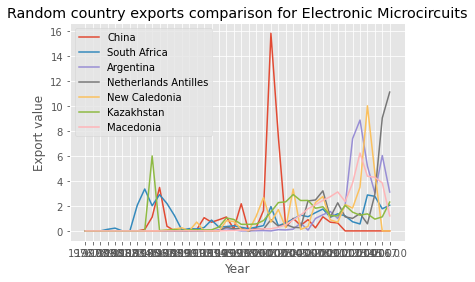

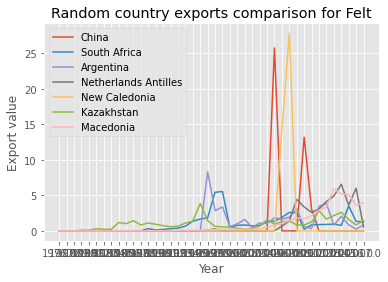

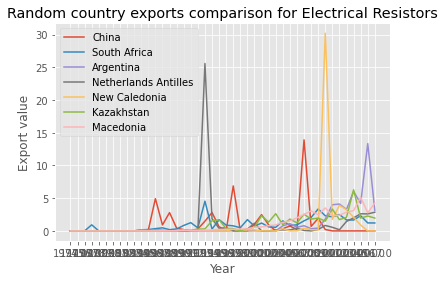

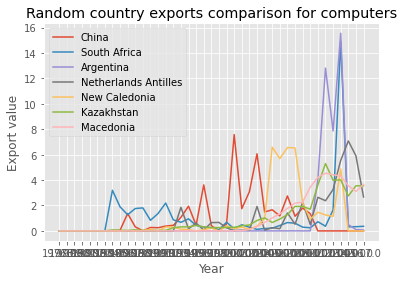

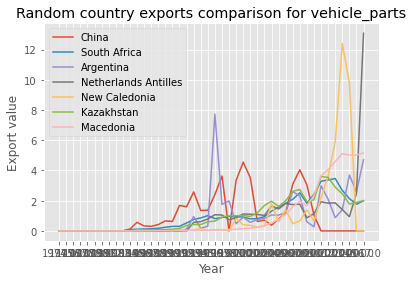

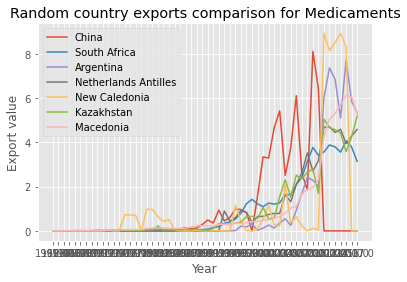

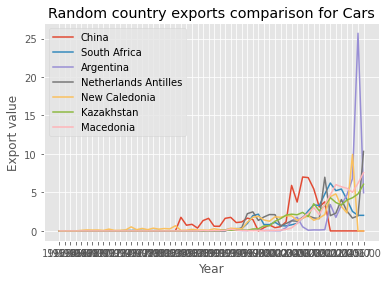

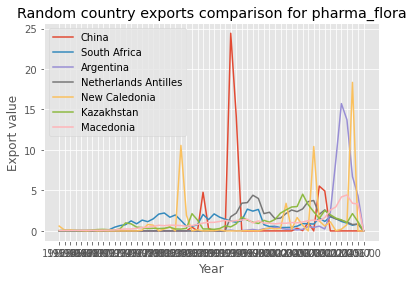

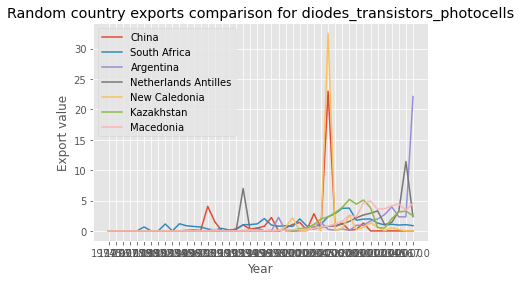

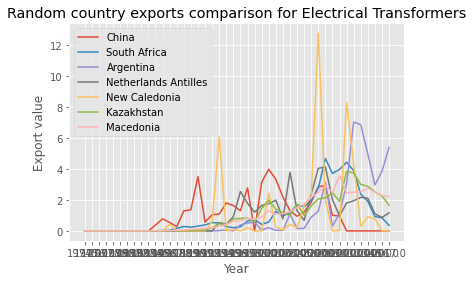

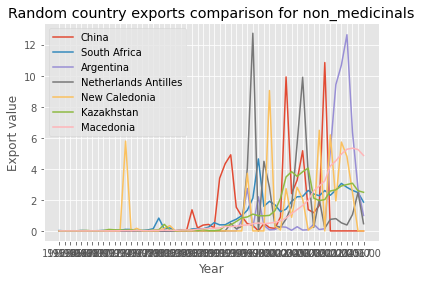

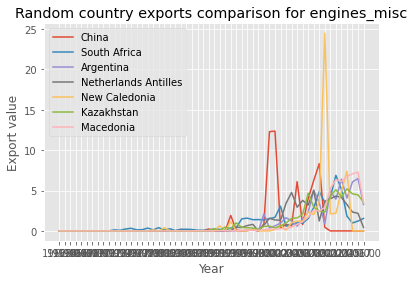

In [14]:
for id in trade_dframe.product_name.unique():
  product = pd.pivot_table(trade_dframe[trade_dframe.product_name==id], 
                           index='year', 
                           columns='country', 
                           values='export_val', 
                           aggfunc=np.mean)
  remove_null_values(product)
  
  mean_scaled_product = product.div(product.mean(axis=0),axis=1)
  mean_scaled_product.to_csv(f'{PATH}/mean_scaled_products/mean_scaled_{id}.csv')
  product_by_countries = mean_scaled_product[random_countries]
  plt.plot(product_by_countries)
  plt.title(f"Random country exports comparison for {id}")
  plt.xlabel("Year")
  plt.ylabel("Export value")
  plt.legend(countries['country'].unique())
  plt.show()

# Clustering 

## Packages for clustering 

In [0]:
!pip install -q dtw-python
# dynamic time warping
from dtw import *
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

from scipy.cluster.vq import kmeans,vq
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics.cluster import homogeneity_score
from sklearn import decomposition
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

## Functions for clustering

In [0]:
# Functions for dendrograms
# given a linkage model, plog dendogram, with the colors indicated by the a cutoff point at which we define clusters
#https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

# Functions for dtw
def get_dtw_diff_matrix(df,cols:list):
    """
    From a list of series, compute a distance matrix by computing the 
    DTW distance of all pairwise combinations of series.
    """
    diff_matrix = {}
    cross = itertools.product(cols, cols)
    for (col1, col2) in cross:
        series1 = df[col1]
        series2 = df[col2]
        diff = dtw(
            series1, 
            series2,
            keep_internals=True, 
            step_pattern=rabinerJuangStepPattern(2, "c")
            )\
            .normalizedDistance
        diff_matrix[(col1, col2)] = [diff]
    return diff_matrix

def plot_dtw(df,series1:str, series2:str) -> None:
    dtw_df = dtw(df[series1],\
            df[series2],\
            keep_internals=True,
            step_pattern=rabinerJuangStepPattern(2, "c"))
    dtw_df.plot(type="twoway",offset=5)
    plt.set_title=(f'{series1} and {series2}')
    plt.show()

## Hierarchical clustering on mean scaled time series

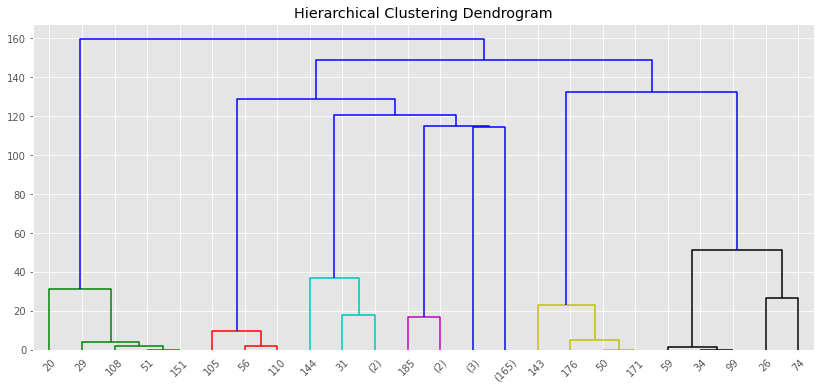

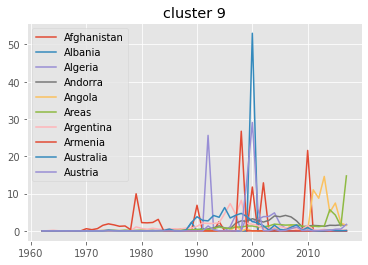

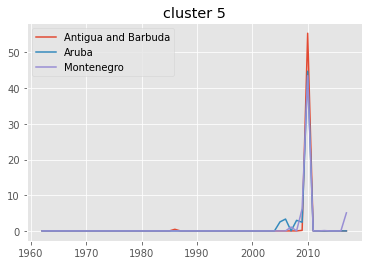

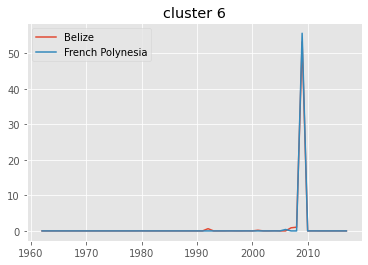

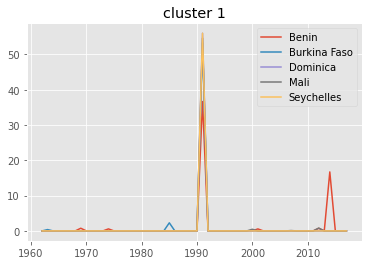

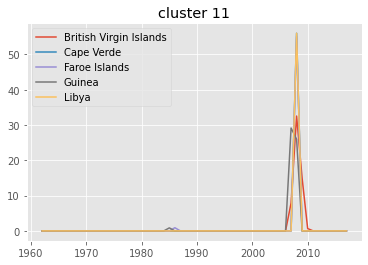

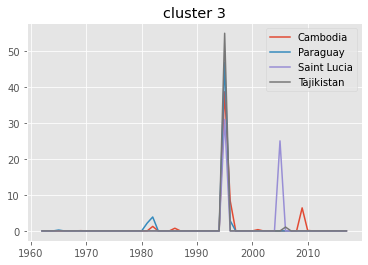

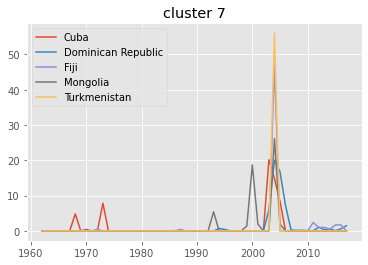

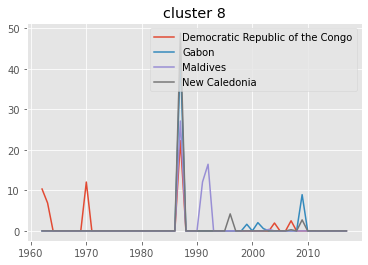

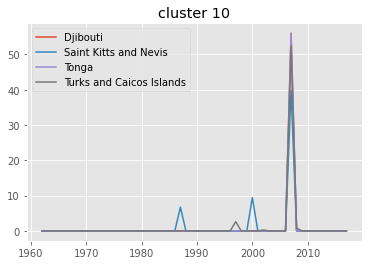

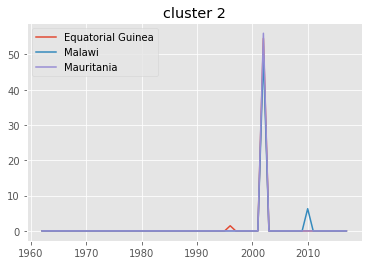

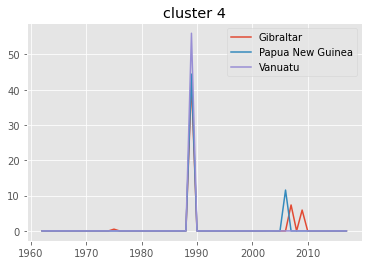

In [18]:
scaled_data_location = f'{PATH}/mean_scaled_products/'
files = os.listdir(scaled_data_location)
files[0]
yarn_fiber = pd.read_csv(f'{scaled_data_location}/{files[0]}',parse_dates=['year'],index_col='year')
remove_null_values(yarn_fiber)

clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(yarn_fiber.T.values)

plt.figure(figsize = (14,6))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top five levels of the dendrogram
 
linkage_matrix = plot_dendrogram(clf, p=5, color_threshold = 110,truncate_mode='level')
plt.show()
# extract clusters from dendogram
clusters = fcluster(linkage_matrix, 100, criterion='distance')
# create a lookup table for series in a given cluster
yarn_fiber_clusters = yarn_fiber.T.reset_index()
yarn_fiber_clusters["cluster"] = clusters
yarn_fiber_clusters.rename(columns={'index':'country'},inplace=True)
yarn_fiber_clustered = yarn_fiber_clusters.set_index("cluster country".split())\
    .sort_index()

# cluster analysis
clusters = yarn_fiber_clusters.cluster.unique()
for c in clusters:
  countries= yarn_fiber_clustered.loc[c].index.get_level_values(0).unique()
  # random.seed(1)
  n_samples = yarn_fiber_clustered.loc[c].shape[0]
  if n_samples > 10:
    n = random.sample(range(n_samples),10)
  else:
    n = range(n_samples)
  cluster = yarn_fiber_clustered.loc[c].T
  plt.plot(cluster.iloc[:, n])
  plt.title(f"cluster {c}")
  plt.legend(countries)
  plt.show()

## Dynamic time warping clustering

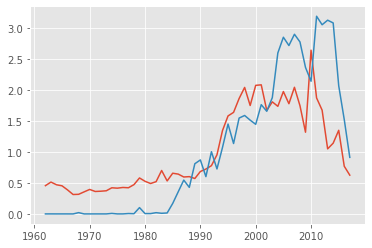

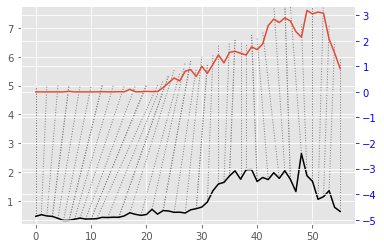

In [19]:
# These two series look similar but are misaligned, it wouldn't be easily visble to the human eye
plt.plot(yarn_fiber[['India','Turkey']])

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(
     yarn_fiber['India'],\
    yarn_fiber['Turkey'],\
    keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(3, "c"))\
    .plot(type="twoway",offset=5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1450: UserWarning: Use the colorbar set_ticks() method instead.
  ax.set_yticks(self.tick_pos)


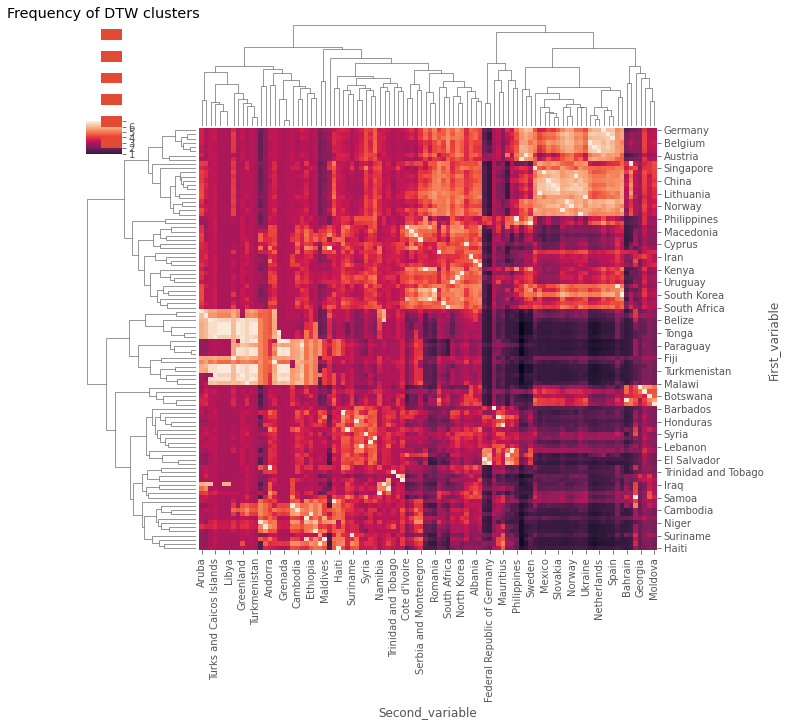

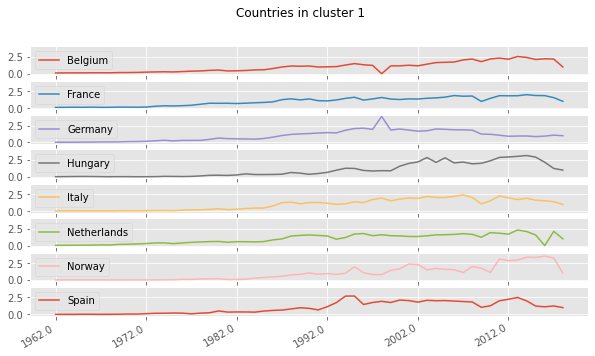

DTW for Turkey and India


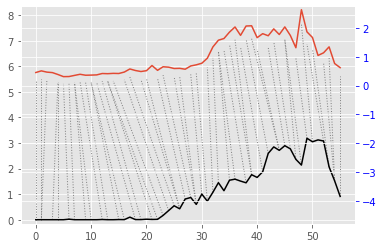

DTW for Rwanda and Montenegro


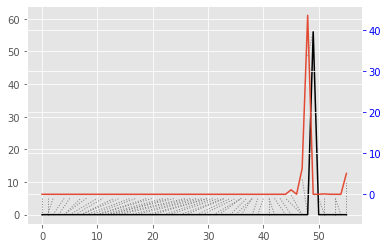

DTW for Niger and Republic of the Congo


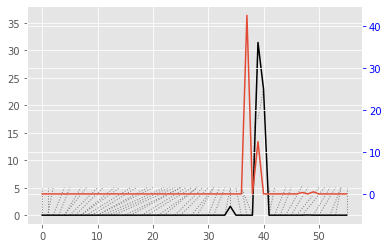

In [25]:
# sample 50 series, and compute the DTW distance matrix
random.seed(10)
sample_cols = random.sample(list(yarn_fiber.columns), 100)
dtw_diff_dict = get_dtw_diff_matrix(yarn_fiber,sample_cols)

# make into a df
dtw_diff_df = pd.DataFrame(dtw_diff_dict).T.reset_index()\
    .rename(columns = {"level_0":"First_variable", "level_1":"Second_variable", 0:"diff"})\
    .pivot_table(index = "First_variable", columns = "Second_variable", values = "diff")

# plot a similarity matrix, with a dendogram imposed
import seaborn as sns
sns.clustermap(1-dtw_diff_df)

# ward clustering from difference matrix, where distance is Dynamic time warping distance instead of Euclidean
time_warp = ward(dtw_diff_df)
# extract clusters
dtw_clusters = pd.DataFrame({"cluster":fcluster(time_warp, 1.15)}, index = dtw_diff_df.index)
dtw_clusters.cluster.value_counts().sort_index().plot.barh()
plt.title("Frequency of DTW clusters")

# Check time series for any cluster
# TODO: Function to loop through all clusters and plot
# What cluster is South Africa? 
#print(dtw_clusters[dtw_clusters.index=='South Africa'])
cluster = 1
yarn_hc_clusters = yarn_fiber.T.merge(
    dtw_clusters.loc[dtw_clusters.cluster ==cluster], 
    left_index = True,
    right_index = True)\
    .T
yarn_hc_clusters.plot(subplots=True,figsize = (10,5.5),sharey=True,title=f'Countries in cluster {cluster}')
plt.show()

print('DTW for Turkey and India')
plot_dtw(yarn_fiber,"Turkey", "India")

print('DTW for Rwanda and Montenegro')
plot_dtw(yarn_fiber,"Rwanda", "Montenegro")

print('DTW for Niger and Republic of the Congo')
plot_dtw(yarn_fiber,"Niger", "Republic of the Congo")

# Extract comprehensive features

### Packages for feature extraction

In [0]:
!pip install -q tsfresh 
import os
import logging
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

from tsfresh import extract_features, select_features
from tsfresh import defaults
from tsfresh.feature_extraction import feature_calculators
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh.utilities import dataframe_functions, profiling
from tsfresh.utilities.distribution import MapDistributor, MultiprocessingDistributor,DistributorBaseClass
from tsfresh.utilities.string_manipulation import convert_to_output_format

import tsfresh
from tsfresh.feature_extraction.settings import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series

### Extract features

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [0]:
trade_dframe.sitc_id.unique()

In [0]:
trade_dframe['sitc_id'].unique()

In [0]:
def extract_product_features(df,fc_parameter,destination):
  features_product = []
  extraction_method = fc_parameter.__class__.__name__
  for p in df.sitc_id.unique():
    product = df[df.sitc_id==p]
    p_features = extract_features(product[["export_val","year","country"]],
                                  column_id="country",
                                  column_sort="year",
                                  column_value=None,column_kind=None,
                                  chunksize=None,
                                  default_fc_parameters=fc_parameter)
    features_product.append(p_features)
    p_features.to_csv(f"{p}_{extraction_method}_expval.csv")
    print(f'Extracted features for {p}: \n {features_product}')
  product_features = pd.concat(features_product)
  return p_features

In [0]:
# %timeit
# destination_1 =f'{PATH}/efficient_parameters'
# destination_2 = f'{PATH}/comprehensive_parameters'
# fc_parameters=[EfficientFCParameters(),ComprehensiveFCParameters()]
# extract_product_features(trade_dframe,fc_parameters[0],destination_1)
# extract_product_features(trade_dframe,fc_parameters[1],destination_2)

# Clustering for minimum extracted features

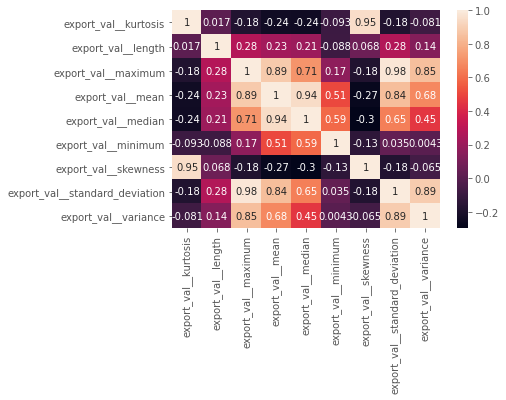

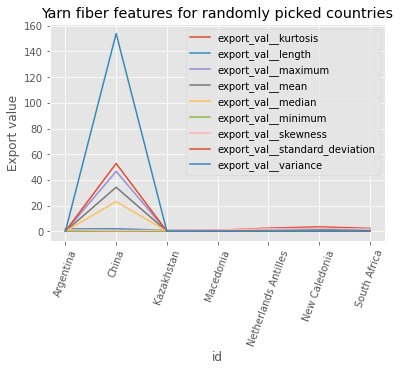

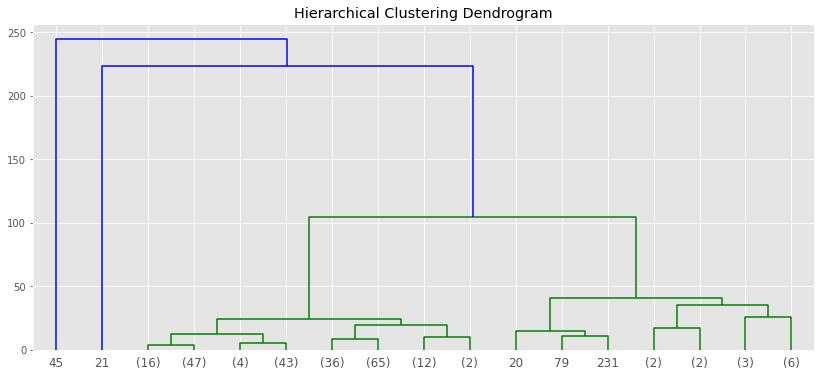

Unique clusters: [1 2 3 4]


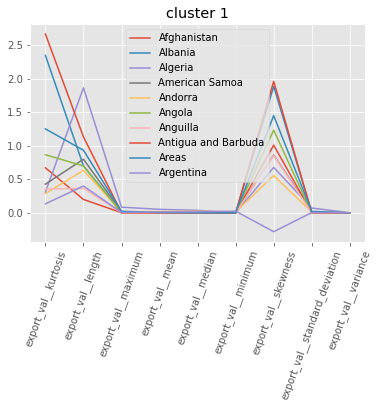

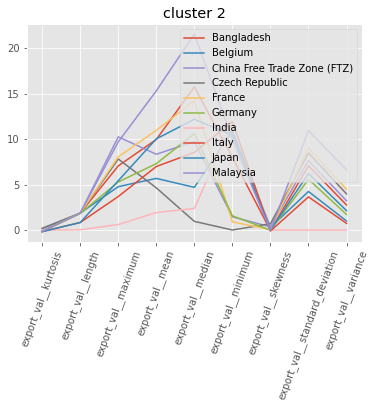

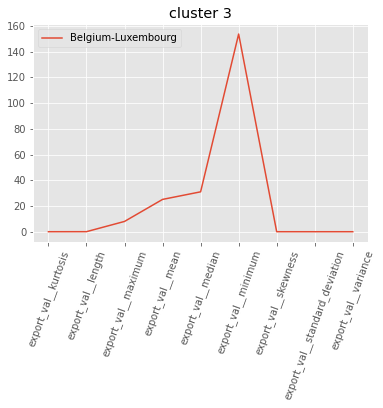

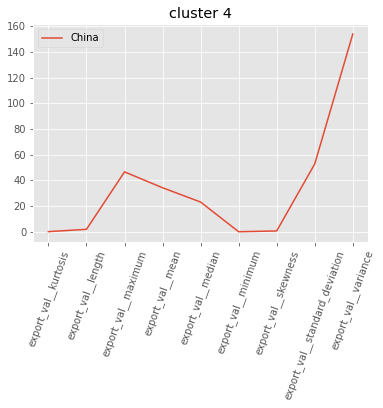

In [150]:
path_to_min_features = f'{PATH}/min_feats_ts'
path_to_parameter_eff_features = f'{PATH}/efficient_parameters'
path_to_parameter_comp_features = f'{PATH}/comprehensive_parameters'
min_feats = os.listdir(path_to_min_features)
yarn_fiber_min_feats = pd.read_csv(f'{path_to_min_features}/{min_feats[0]}',index_col='id')
remove_null_values(yarn_fiber_min_feats)

# Exclude highly correlated features
exclude = [
          #  'export_val__kurtosis',
          #  'export_val__variance',
           'export_val__sum_values',
          #  'export_val__standard_deviation',
          #  'export_val__median',
          #  'export_val__maximum'
           ]
min_feats_yarn = yarn_fiber_min_feats[
                                      yarn_fiber_min_feats.columns[
                                                                   ~yarn_fiber_min_feats.columns.isin(exclude)
                                                                   ]
                                      ]
sns.heatmap(min_feats_yarn.corr(),annot=True)

min_feats_yarn = min_feats_yarn.div(min_feats_yarn.mean(axis=0),axis=1)

product_by_countries = min_feats_yarn[min_feats_yarn.index.isin(random_countries)]
product_by_countries.plot(title="Yarn fiber features for randomly picked countries")
plt.xticks(rotation=70)
plt.ylabel("Export value")
# plt.legend(random_countries)
plt.show()
feats_clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(min_feats_yarn.values)

plt.figure(figsize = (14,6))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top five levels of the dendrogram
linkage_matrix = plot_dendrogram(feats_clf, p=5,color_threshold = 110,truncate_mode='level')
plt.show()

# extract clusters from dendogram
clusters = fcluster(linkage_matrix, 100, criterion='distance')
# create a lookup table for series in a given cluster
yarn_fiber_clusters = min_feats_yarn .reset_index()
yarn_fiber_clusters["cluster"] = clusters
clusts = yarn_fiber_clusters['cluster'].unique()
print(f'Unique clusters: {clusts}')
yarn_fiber_clusters.rename(columns={'id':'country'},inplace=True)
yarn_fiber_clustered = yarn_fiber_clusters.set_index("cluster country".split())\
.sort_index()


# cluster analysis
feats_clusters = yarn_fiber_clusters.cluster.unique()
for c in feats_clusters:
  countries= yarn_fiber_clustered.loc[c].index.get_level_values(0).unique()
  # random.seed(1)
  n_samples = yarn_fiber_clustered.loc[c].shape[0]
  if n_samples > 10:
    n = random.sample(range(n_samples),10)
  else:
    n = range(n_samples)
  cluster = yarn_fiber_clustered.loc[c].T
  plt.plot(cluster.iloc[:, n])
  plt.xticks(rotation=70)
  plt.title(f"cluster {c}")
  plt.legend(countries)
  plt.show()

## K-means clusetring

In [0]:
range_n_clusters = range(2,20)
elbow = []
s_score = []
for n_clusters in range_n_clusters:
   clusterer = KMeans(n_clusters = n_clusters, random_state=42,init='k-means++',max_iter=1000,n_init=1)
   cluster_labels = clusterer.fit_predict(X)
   # Average silhouette score
   silhouette_avg = silhouette_score(X, cluster_labels)
   s_score.append(silhouette_avg)
   # Average SSE"
   elbow.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center

fig = plt.figure(figsize=(14,7))

fig.add_subplot(121)
plt.title("Covid-19 Rt values elbow method results")
plt.plot(range_n_clusters, elbow,'b-',label='Sum of squared error')
plt.xlabel("Number of cluster")
plt.ylabel("Sum of squared error(SSE)")
plt.legend()

fig.add_subplot(122)
plt.title("Covid-19 Rt values silhouette method results")
plt.plot(range_n_clusters, s_score,'b-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()